In [2]:
# Inspired from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue/notebook
import gc
import re
import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from scipy.stats import norm, probplot

In [3]:
IN_TRAIN = 'in/train-flat.csv'
IN_TEST = 'in/test-flat.csv'

OUT_TRAIN = 'in/train-pruned.csv'
OUT_TEST = 'in/test-pruned.csv'

In [4]:
%%time
train_df = pd.read_csv(IN_TRAIN, dtype={'fullVisitorId': 'str'}, low_memory=False)

CPU times: user 14.6 s, sys: 864 ms, total: 15.4 s
Wall time: 15.4 s


In [6]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [7]:
%%time
test_df = pd.read_csv(IN_TEST, dtype={'fullVisitorId': 'str'}, low_memory=False)

CPU times: user 12.5 s, sys: 804 ms, total: 13.3 s
Wall time: 13.9 s


In [8]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [41]:
x = train_df["totals.transactionRevenue"]
100*(len(x) - len([y for y in x if np.isnan(y)]))/len(x)

1.27427231470487

In [45]:
sorted(x.unique())

[nan,
 10000.0,
 40000.0,
 90000.0,
 160000.0,
 200000.0,
 490000.0,
 770000.0,
 790000.0,
 990000.0,
 1200000.0,
 1470000.0,
 1500000.0,
 1550000.0,
 1560000.0,
 1590000.0,
 1680000.0,
 1840000.0,
 1890000.0,
 1980000.0,
 1990000.0,
 2160000.0,
 2340000.0,
 2390000.0,
 2400000.0,
 2480000.0,
 2490000.0,
 2500000.0,
 2530000.0,
 2690000.0,
 2730000.0,
 2800000.0,
 2830000.0,
 2860000.0,
 2990000.0,
 3180000.0,
 3190000.0,
 3240000.0,
 3260000.0,
 3490000.0,
 3500000.0,
 3590000.0,
 3600000.0,
 3910000.0,
 3960000.0,
 3980000.0,
 3990000.0,
 4380000.0,
 4390000.0,
 4500000.0,
 4560000.0,
 4770000.0,
 4780000.0,
 4960000.0,
 4980000.0,
 4990000.0,
 5030000.0,
 5090000.0,
 5150000.0,
 5480000.0,
 5490000.0,
 5500000.0,
 5560000.0,
 5570000.0,
 5580000.0,
 5590000.0,
 5700000.0,
 5970000.0,
 5980000.0,
 5990000.0,
 6000000.0,
 6070000.0,
 6150000.0,
 6170000.0,
 6230000.0,
 6370000.0,
 6380000.0,
 6390000.0,
 6490000.0,
 6690000.0,
 6700000.0,
 6970000.0,
 6980000.0,
 6990000.0,
 7000000.0

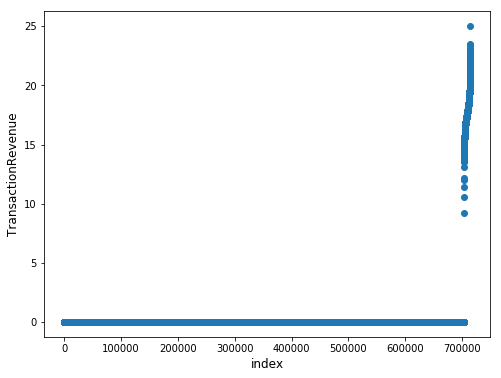

In [9]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [10]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [11]:
# remove cols which are not available in demo dataset
# TODO
# cols_not_available_in_demo_dataset = 
train_df.iloc[0] == 'not available in demo dataset'

channelGrouping                                      False
date                                                 False
fullVisitorId                                        False
sessionId                                            False
socialEngagementType                                 False
visitId                                              False
visitNumber                                          False
visitStartTime                                       False
device.browser                                       False
device.browserSize                                    True
device.browserVersion                                 True
device.deviceCategory                                False
device.flashVersion                                   True
device.isMobile                                      False
device.language                                       True
device.mobileDeviceBranding                           True
device.mobileDeviceInfo                               Tr